# Customer Churn Prediction with XGBoost
_**Using Gradient Boosted Trees to Predict Mobile Customer Departure**_

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
  1. [Relative cost of errors](#Relative-cost-of-errors)
1. [Extensions](#Extensions)

---

## Background

_This notebook has been adapted from an [AWS blog post](https://aws.amazon.com/blogs/ai/predicting-customer-churn-with-amazon-machine-learning/)_

Losing customers is costly for any business.  Identifying unhappy customers early on gives you a chance to offer them incentives to stay.  This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

We use an example of churn that is familiar to all of us–leaving a mobile phone operator.  Seems like I can always find fault with my provider du jour! And if my provider knows that I’m thinking of leaving, it can offer timely incentives–I can always use a phone upgrade or perhaps have a new feature activated–and I might just stick around. Incentives are often much more cost effective than losing and reacquiring a customer.

---

## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [2]:
# Define IAM role
import boto3
import re
import sagemaker

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
bucket = 'sagemaker-rul-xgboost'
prefix = 'DEMO-xgboost-rul-mod2'

Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer

---
## Data

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes–after all, predicting the future is tricky business! But I’ll also show how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.  Let's download and read that dataset in now:

In [103]:
'''traindf = pd.read_csv('Data/train-01.csv', index_col=0)
col = ['RUL', 'setting1', 'setting2', 's2', 's3',
       's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14',
       's15', 's17', 's20', 's21']

traindf = traindf[col]

print(traindf)
'''

datadf = pd.read_csv('mixsensor.csv', index_col = 0)
#print(datadf)
#datadf_1 = datadf[datadf['machineID']==1]
datadf_1=datadf[datadf['datetime']>='2015-01-05 06:00:00']
col = ['MTBF', 'volt', 'rotate', 'pressure', 'vibration']
datadf_1 = datadf_1[col]
def normalize(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))
    #dataNorm["MTBF"]=dataset["MTBF"]
    return dataNorm
datadf_2=normalize(datadf_1)
#train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
datatrain, datavalid, datatest = np.split(datadf_2.sample(frac=1), [int(0.7*len(datadf_2)), int(0.9*len(datadf_2))])                                                                                                   
print(datatrain)
print(datavalid)
print(datatest)

#datatrain=datadf_2.loc[96:858577]
#datavalid=datadf_2.loc[858578:867339]
#datatest=datadf_2.loc[867340:876099]
#datatrain = datadf_2.loc[0:6935]
#datavalid = datadf_2.loc[6936:8375]
#datatest = datadf_2.loc[8376:]


            MTBF      volt    rotate  pressure  vibration
146053  0.152585  0.439017  0.539795  0.371881   0.284431
241557  0.044898  0.465534  0.431772  0.277914   0.314561
66611   0.193329  0.573810  0.410570  0.455903   0.464794
105497  0.234765  0.493593  0.471226  0.370367   0.326053
468376  0.029086  0.367635  0.496654  0.528290   0.354056
...          ...       ...       ...       ...        ...
437603  0.051477  0.528755  0.522098  0.304746   0.608945
621172  0.099030  0.353725  0.659325  0.330088   0.362949
56546   0.061288  0.314007  0.446561  0.306057   0.406658
311311  0.141620  0.481412  0.421602  0.476174   0.333724
5052    0.092682  0.442293  0.414273  0.356543   0.426589

[606550 rows x 5 columns]
            MTBF      volt    rotate  pressure  vibration
513014  0.029894  0.365548  0.423102  0.379115   0.403151
388597  0.031163  0.600551  0.540574  0.312926   0.497423
840138  0.097415  0.368652  0.635288  0.404950   0.459765
703122  0.034741  0.480561  0.340145  0.38517

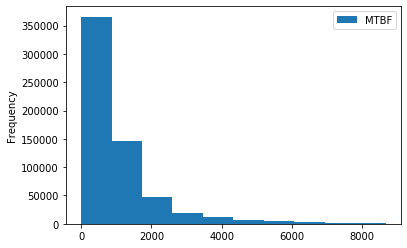

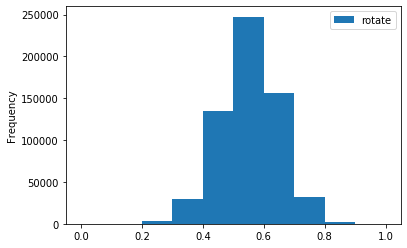

OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

<Figure size 432x288 with 1 Axes>

OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

<Figure size 432x288 with 1 Axes>

In [91]:
datatrain.plot.hist(x="volt", y="MTBF")
datatrain.plot.hist(x="MTBF", y="rotate")
datatrain.plot(x="pressure", y="MTBF")
datatrain.plot(x="vibration", y="MTBF")

In [279]:
testdf = pd.read_csv('Data/test-01.csv', index_col=0)

col = ['RUL', 'setting1', 'setting2', 's2', 's3',
       's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14',
       's15', 's17', 's20', 's21']

testdf = testdf[col]
#testdf = testdf.insert(2,'Predict',True)
#testdf = testdf.insert(2,'Predict',True)
#traindf = traindf.insert(2,'Predict',True)
print(testdf)



       RUL  setting1  setting2        s2        s3        s4        s7  \
0      142  0.656271  0.692544  0.596215  0.421968  0.282214  0.608871   
1      141  0.343791  0.231360  0.182966  0.504025  0.225240  0.800403   
2      140  0.531279  0.538816  0.419559  0.464814  0.346130  0.651210   
3      139  0.775014  0.461952  0.413249  0.391587  0.449867  0.643145   
4      138  0.600025  0.461952  0.435331  0.471306  0.357974  0.661290   
...    ...       ...       ...       ...       ...       ...       ...   
13091   24  0.818761  0.461952  0.665615  0.789665  0.641209  0.510081   
13092   23  0.443785  0.385088  0.659306  0.692028  0.769042  0.471774   
13093   22  0.475033  0.231360  0.728707  0.626071  0.458036  0.435484   
13094   21  0.275045  0.538816  0.671924  0.673851  0.714111  0.502016   
13095   20  0.593775  0.692544  0.574133  0.846014  0.829079  0.322581   

             s8        s9       s11       s12       s13       s14       s15  \
0      0.365855  0.196475  0.273

In [280]:
#model_data = pd.get_dummies(churn)
#model_data = pd.concat([model_data['Churn?_True.'], model_data.drop(['Churn?_False.', 'Churn?_True.'], axis=1)], axis=1)
#model_data
#model_data=testdf.drop(columns = ['RUL'])
model_data=testdf
model_data

,RUL,setting1,setting2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,142,0.656271,0.692544,0.596215,0.421968,0.282214,0.608871,0.365855,0.196475,0.273973,0.534247,0.325583,0.152259,0.347079,0.375,0.500000,0.620100
1,141,0.343791,0.231360,0.182966,0.504025,0.225240,0.800403,0.292685,0.229042,0.479452,0.634703,0.395350,0.277907,0.227712,0.500,0.645455,0.645719
2,140,0.531279,0.538816,0.419559,0.464814,0.346130,0.651210,0.390245,0.248506,0.479452,0.591324,0.325583,0.192892,0.533559,0.500,0.700000,0.681104
3,139,0.775014,0.461952,0.413249,0.391587,0.449867,0.643145,0.341465,0.159080,0.328768,0.456621,0.372094,0.217896,0.282362,0.250,0.627273,0.620383
4,138,0.600025,0.461952,0.435331,0.471306,0.357974,0.661290,0.292685,0.153410,0.349316,0.632420,0.325583,0.187891,0.337012,0.125,0.618182,0.676009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,24,0.818761,0.461952,0.665615,0.789665,0.641209,0.510081,0.317075,0.902989,0.609589,0.299087,0.255816,0.935703,0.664911,0.625,0.309092,0.370843
13092,23,0.443785,0.385088,0.659306,0.692028,0.769042,0.471774,0.390245,0.890038,0.547946,0.381279,0.465118,0.914003,0.567596,0.750,0.236364,0.483653
13093,22,0.475033,0.231360,0.728707,0.626071,0.458036,0.435484,0.536586,0.937011,0.527398,0.410959,0.348839,0.971066,0.594920,0.750,0.281819,0.381742
13094,21,0.275045,0.538816,0.671924,0.673851,0.714111,0.502016,0.439026,0.952644,0.554795,0.445206,0.441862,1.000000,0.662993,0.750,0.318182,0.473461


And now let's split the data into training, validation, and test sets.  This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

In [104]:
#train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
#print(len(train_data))
#print(len(validation_data))
#print(len(test_data))

#traindf.to_csv('train.csv', header=False, index=False)
datatrain.to_csv('datatrain.csv', header=False, index=False)
#validation_data.to_csv('validation.csv', header=False, index=False)
datavalid.to_csv('datavalid.csv', header=False, index=False)

Now we'll upload these files to S3.

In [105]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'datatrain/datatrain.csv')).upload_file('datatrain.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'datavalid/datavalid.csv')).upload_file('datavalid.csv')
#boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---
## Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.

In [106]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost', '1.0-1')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3.

In [107]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/datatrain'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/datavalid'.format(bucket, prefix), content_type='csv')
#s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [108]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=1,
                        gamma=4,
                        min_child_weight=5,
                        subsample=0.8,
                        silent=0,
                        objective='reg:squarederror',
                        eval_metric='mae',
                        num_round=100)

#xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-09-25 13:10:42 Starting - Starting the training job...
2020-09-25 13:10:44 Starting - Launching requested ML instances......
2020-09-25 13:12:10 Starting - Preparing the instances for training......
2020-09-25 13:13:04 Downloading - Downloading input data...
2020-09-25 13:13:23 Training - Downloading the training image...
2020-09-25 13:13:51 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value mae to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','


---
## Host

Now that we've trained the algorithm, let's create a model and deploy it to a hosted endpoint.

In [109]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [110]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array
Printing testdate before and after split

In [111]:
print(datatest)


            MTBF      volt    rotate  pressure  vibration
372065  0.080332  0.491448  0.751678  0.402017   0.294423
713162  0.540859  0.582854  0.506428  0.451654   0.507079
9091    0.175092  0.410690  0.611847  0.337330   0.392834
616798  0.035896  0.586228  0.544481  0.459218   0.316207
298102  0.070522  0.550304  0.535353  0.357489   0.381640
...          ...       ...       ...       ...        ...
596961  0.161819  0.402473  0.496863  0.324902   0.400570
112702  0.067982  0.542161  0.465464  0.335405   0.405409
333905  0.135272  0.457483  0.455659  0.445672   0.408330
620243  0.206256  0.531465  0.621514  0.517696   0.438800
373827  0.084718  0.553891  0.679532  0.367437   0.425939

[86650 rows x 5 columns]


In [100]:
split_array = np.array_split((datatest.iloc[0:, 1:]).to_numpy(), int((datatest.iloc[0:, 1:]).to_numpy().shape[0] / float(500) + 1))
print(split_array)


[array([[0.65689901, 0.64735962, 0.51562489, 0.29379031],
       [0.45419823, 0.45061138, 0.49265288, 0.29210966],
       [0.49009731, 0.65832813, 0.32462464, 0.48416739],
       ...,
       [0.48743002, 0.5205085 , 0.27733847, 0.54237815],
       [0.40070058, 0.50032753, 0.32145109, 0.41682769],
       [0.40306031, 0.51113841, 0.37511361, 0.49688617]]), array([[0.55462211, 0.49029016, 0.35504862, 0.30825597],
       [0.47615645, 0.61618568, 0.43758999, 0.32311655],
       [0.43385166, 0.57622174, 0.28866493, 0.36761224],
       ...,
       [0.39573522, 0.56251676, 0.23090944, 0.4416822 ],
       [0.63507269, 0.68824528, 0.27390676, 0.30655865],
       [0.3756224 , 0.62708086, 0.25959717, 0.2989122 ]]), array([[0.55121912, 0.41505625, 0.2536191 , 0.38605136],
       [0.34667848, 0.63653611, 0.47878511, 0.72800429],
       [0.5121248 , 0.42027287, 0.32628086, 0.26901482],
       ...,
       [0.40245869, 0.55392693, 0.32719274, 0.35259334],
       [0.49220695, 0.54406155, 0.3226841 , 0.6

In [112]:
from sklearn.metrics import accuracy_score
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict((datatest.iloc[0:, 1:]).to_numpy())
pdf = pd.DataFrame(columns = ['Actual RUL', 'Predicted RUL'])
pdf['Actual RUL'] = datatest['MTBF']


pdf['Predicted RUL'] = predictions
#acc=accuracy_score(pdf['Actual RUL'],pdf['Predicted RUL'] )
#print(acc)
print(pdf)
pdf.to_csv('pdfnew.csv')

        Actual RUL  Predicted RUL
372065    0.080332       0.118379
713162    0.540859       0.118379
9091      0.175092       0.118379
616798    0.035896       0.118379
298102    0.070522       0.118379
...            ...            ...
596961    0.161819       0.118379
112702    0.067982       0.118379
333905    0.135272       0.118379
620243    0.206256       0.118379
373827    0.084718       0.118379

[86650 rows x 2 columns]


There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values.  In this case, we're simply predicting whether the customer churned (`1`) or not (`0`), which produces a simple confusion matrix.

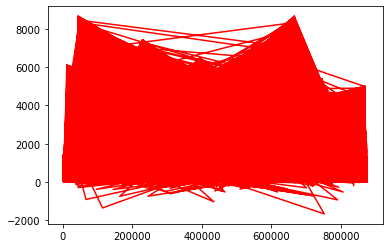

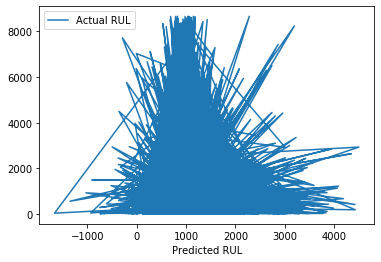

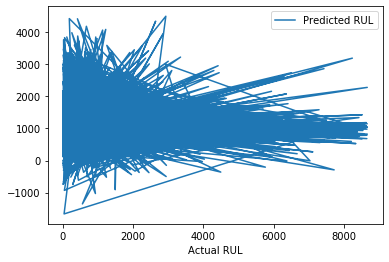

In [102]:
predictions.shape
plt.plot(pdf, color='red', label='RUL')
pdf.plot(x="Predicted RUL", y="Actual RUL")
pdf.plot(x="Actual RUL", y="Predicted RUL")
#pdf.plot(x="id", y=["Actual RUL", "Predicted RUL"])
#pdf.plot(x="Actual RUL", y="Predicted RUL")
#pdf.plot(x="Cycle", y="Actual RUL")

In [155]:
conmat = pd.DataFrame(pd.crosstab(index=testdf.iloc[:, 0], columns=  np.round(predictions), rownames=['actual'], colnames=['predictions']))
conmat.to_csv('conmat.csv')

_Note, due to randomized elements of the algorithm, you results may differ slightly._

Of the 48 churners, we've correctly predicted 39 of them (true positives). And, we incorrectly predicted 4 customers would churn who then ended up not doing so (false positives).  There are also 9 customers who ended up churning, that we predicted would not (false negatives).

An important point here is that because of the `np.round()` function above we are using a simple threshold (or cutoff) of 0.5.  Our predictions from `xgboost` come out as continuous values between 0 and 1 and we force them into the binary classes that we began with.  However, because a customer that churns is expected to cost the company more than proactively trying to retain a customer who we think might churn, we should consider adjusting this cutoff.  That will almost certainly increase the number of false positives, but it can also be expected to increase the number of true positives and reduce the number of false negatives.

To get a rough intuition here, let's look at the continuous values of our predictions.

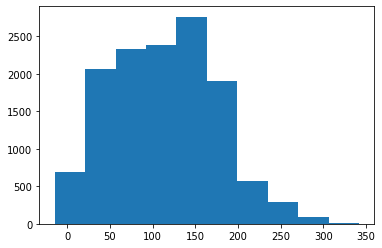

[156.11909485 191.92297363 174.14207458 ...  10.16726589   6.97060442
   5.1840601 ]


In [132]:
plt.hist(predictions)
plt.show()
print(predictions)

The continuous valued predictions coming from our model tend to skew toward 0 or 1, but there is sufficient mass between 0.1 and 0.9 that adjusting the cutoff should indeed shift a number of customers' predictions.  For example...

In [23]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.3, 1, 0))

col_0,0,1
Churn?_True.,,
0,279,7
1,8,40


We can see that changing the cutoff from 0.5 to 0.3 results in 1 more true positives, 3 more false positives, and 1 fewer false negatives.  The numbers are small overall here, but that's 6-10% of customers overall that are shifting because of a change to the cutoff.  Was this the right decision?  We may end up retaining 3 extra customers, but we also unnecessarily incentivized 5 more customers who would have stayed.  Determining optimal cutoffs is a key step in properly applying machine learning in a real-world setting.  Let's discuss this more broadly and then apply a specific, hypothetical solution for our current problem.

### Relative cost of errors

Any practical binary classification problem is likely to produce a similarly sensitive cutoff. That by itself isn’t a problem. After all, if the scores for two classes are really easy to separate, the problem probably isn’t very hard to begin with and might even be solvable with simple rules instead of ML.

More important, if I put an ML model into production, there are costs associated with the model erroneously assigning false positives and false negatives. I also need to look at similar costs associated with correct predictions of true positives and true negatives.  Because the choice of the cutoff affects all four of these statistics, I need to consider the relative costs to the business for each of these four outcomes for each prediction.

#### Assigning costs

What are the costs for our problem of mobile operator churn? The costs, of course, depend on the specific actions that the business takes. Let's make some assumptions here.

First, assign the true negatives the cost of \$0. Our model essentially correctly identified a happy customer in this case, and we don’t need to do anything.

False negatives are the most problematic, because they incorrectly predict that a churning customer will stay. We lose the customer and will have to pay all the costs of acquiring a replacement customer, including foregone revenue, advertising costs, administrative costs, point of sale costs, and likely a phone hardware subsidy. A quick search on the Internet reveals that such costs typically run in the hundreds of dollars so, for the purposes of this example, let's assume \$500. This is the cost of false negatives.

Finally, for customers that our model identifies as churning, let's assume a retention incentive in the amount of \\$100. If my provider offered me such a concession, I’d certainly think twice before leaving. This is the cost of both true positive and false positive outcomes. In the case of false positives (the customer is happy, but the model mistakenly predicted churn), we will “waste” the \\$100 concession. We probably could have spent that \\$100 more effectively, but it's possible we increased the loyalty of an already loyal customer, so that’s not so bad.

#### Finding the optimal cutoff

It’s clear that false negatives are substantially more costly than false positives. Instead of optimizing for error based on the number of customers, we should be minimizing a cost function that looks like this:

```txt
$500 * FN(C) + $0 * TN(C) + $100 * FP(C) + $100 * TP(C)
```

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP.  We need to find the cutoff, C, where the result of the expression is smallest.

A straightforward way to do this, is to simply run a simulation over a large number of possible cutoffs.  We test 100 possible values in the for loop below.

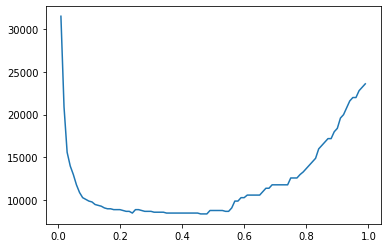

Cost is minimized near a cutoff of: 0.46 for a cost of: 8400


In [24]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[0, 100], [500, 100]]) * 
                               pd.crosstab(index=test_data.iloc[:, 0], 
                                           columns=np.where(predictions > c, 1, 0)))))

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))

The above chart shows how picking a threshold too low results in costs skyrocketing as all customers are given a retention incentive.  Meanwhile, setting the threshold too high results in too many lost customers, which ultimately grows to be nearly as costly.  The overall cost can be minimized at \\$ 8400 by setting the cutoff to 0.46, which is substantially better than the
\\$ 20k+ I would expect to lose by not taking any action.

---
## Extensions

This notebook showcased how to build a model that predicts whether a customer is likely to churn, and then how to optimally set a threshold that accounts for the cost of true positives, false positives, and false negatives.  There are several means of extending it including:
- Some customers who receive retention incentives will still churn.  Including a probability of churning despite receiving an incentive in our cost function would provide a better ROI on our retention programs.
- Customers who switch to a lower-priced plan or who deactivate a paid feature represent different kinds of churn that could be modeled separately.
- Modeling the evolution of customer behavior. If usage is dropping and the number of calls placed to Customer Service is increasing, you are more likely to experience churn then if the trend is the opposite. A customer profile should incorporate behavior trends.
- Actual training data and monetary cost assignments could be more complex.
- Multiple models for each type of churn could be needed.

Regardless of additional complexity, similar principles described in this notebook are likely apply.

### Optimizing model for prediction using Neo API
Neo API allows to optimize our model for a specific hardware type. When calling `compile_model()` function, we specify the target instance family (C5) as well as the S3 bucket to which the compiled model would be stored.

**Important. If the following command result in a permission error, scroll up and locate the value of execution role returned by `get_execution_role()`. The role must have access to the S3 bucket specified in ``output_path``.**

In [227]:
output_path = '/'.join(xgb.output_path.split('/')[:-1])
print(output_path)
compiled_model = xgb.compile_model(target_instance_family='rasp3b',
                                   target_platform_os="LINUX",
                                   target_platform_arch="ARM_EABIHF",
                                   input_shape={'data':[1, 26]},
                                   role=role,
                                   framework='xgboost',
                                   output_path=output_path)


#framework_version='1.2.0',

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


s3://sagemaker-rul-xgboost/DEMO-xgboost-rul-mod2
?.*

UnexpectedStatusException: Error for Compilation job compilation-sagemaker-xgboost-2020-09-23-12-16-24-827: Failed. Reason: ClientError: InputConfiguration: Treelite failed to convert XGBoost model. Please make sure the framework you select is correct. std::bad_alloc

### Creating an inference Endpoint

We can deploy this compiled model, note that we need to use the same instance that the target we used for compilation. This creates a SageMaker endpoint that we can use to perform inference. 

The arguments to the ``deploy`` function allow us to set the number and type of instances that will be used for the Endpoint. Make sure to choose an instance for which you have compiled your model, so in our case  `ml_c5`. Neo API uses a special runtime (DLR runtime), in which our optimzed model will run.

In [ ]:
# # known issue: need to manually specify endpoint name
compiled_model.name = 'deployed-xgboost-rul'
# # There is a known issue where SageMaker SDK locates the incorrect docker image URI for XGBoost
# # For now, we manually set Image URI
compiled_model.image = get_image_uri(sess.boto_region_name, 'xgboost-neo', repo_version='latest')
compiled_predictor = compiled_model.deploy(initial_instance_count = 1, instance_type = 'ml.c5.4xlarge')

### Making an inference request
The compiled model accepts CSV content type:

In [134]:
compiled_predictor.content_type = 'text/csv'
compiled_predictor.serializer = csv_serializer
compiled_predictor.deserializer = None

NameError: name 'compiled_predictor' is not defined

In [30]:
def optimized_predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, compiled_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = optimized_predict((test_data.iloc[0:, 1:]).to_numpy())

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from model with message "Your invocation timed out while waiting for a response from container model. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://ap-southeast-1.console.aws.amazon.com/cloudwatch/home?region=ap-southeast-1#logEventViewer:group=/aws/sagemaker/Endpoints/deployed-xgboost-customer-churn1 in account 018166606076 for more information.

In [ ]:
predictions

### (Optional) Clean-up

If you're ready to be done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [61]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)
#sagemaker.Session().delete_endpoint(compiled_predictor.endpoint)